In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [2]:

! pip install -q kaggle



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.json': Permission denied


In [3]:
!kaggle datasets download -d 'alessiocorrado99/animals10'

animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from os import path
if(path.exists('animals')==False):
  ! unzip animals10.zip -d animals


In [5]:
! ls animals/raw-img/scoiattolo/ | wc -l

1862


In [6]:
import os
#dir = os.listdir('/content/')

canedir = 'animals/raw-img/cane/'
cavallo = 'animals/raw-img/cavallo/'
elefante = 'animals/raw-img/elefante/'
farfalla = 'animals/raw-img/farfalla/'
gallina = 'animals/raw-img/gallina/'
gatto = 'animals/raw-img/gatto/'
mucca = 'animals/raw-img/mucca/'
pecora = 'animals/raw-img/pecora/'
ragno = 'animals/raw-img/ragno/'
scoiattolo = 'animals/raw-img/scoiattolo/'


import pathlib
path = pathlib.Path.cwd() / scoiattolo

image_count = len(list(path.glob('*')))
print(image_count)

print(path)

1862
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/animals/raw-img/scoiattolo


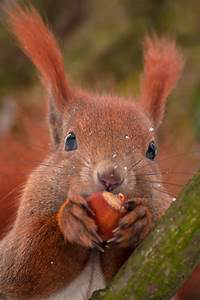

In [7]:
wiewiorka = list(path.glob('*'))
PIL.Image.open(str(wiewiorka[0]))

In [8]:
img_height = 180
img_width = 180
batch_size = 32

path = pathlib.Path.cwd() / 'animals/raw-img'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

class_names = train_ds.class_names
print(class_names)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


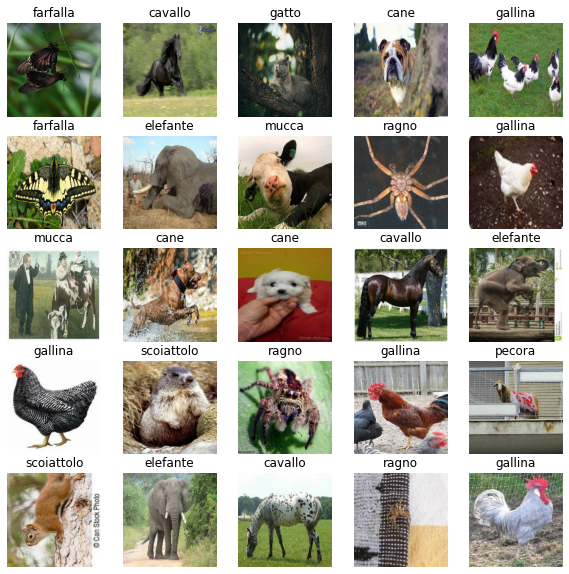

In [10]:
import matplotlib.pyplot as plt

tf.keras.layers.experimental.preprocessing.Resizing(
    img_height, img_width, interpolation='bilinear', name=None
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = 10


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [15]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
655/655 [==============================] - 247s 375ms/step - loss: 1.8849 - accuracy: 0.3404 - val_loss: 1.3226 - val_accuracy: 0.5545
Epoch 2/10
655/655 [==============================] - 219s 334ms/step - loss: 1.1703 - accuracy: 0.6071 - val_loss: 1.1640 - val_accuracy: 0.6191
Epoch 3/10
655/655 [==============================] - 214s 327ms/step - loss: 0.8037 - accuracy: 0.7330 - val_loss: 1.1607 - val_accuracy: 0.6199
Epoch 4/10
655/655 [==============================] - 267s 407ms/step - loss: 0.4864 - accuracy: 0.8387 - val_loss: 1.2175 - val_accuracy: 0.6577
Epoch 5/10
655/655 [==============================] - 266s 406ms/step - loss: 0.2436 - accuracy: 0.9229 - val_loss: 1.4222 - val_accuracy: 0.6311
Epoch 6/10
655/655 [==============================] - 254s 387ms/step - loss: 0.1158 - accuracy: 0.9651 - val_loss: 1.9045 - val_accuracy: 0.6319
Epoch 7/10
655/655 [==============================] - 243s 371ms/step - loss: 0.0612 - accuracy: 0.9824 - val_loss: 2.2115 -

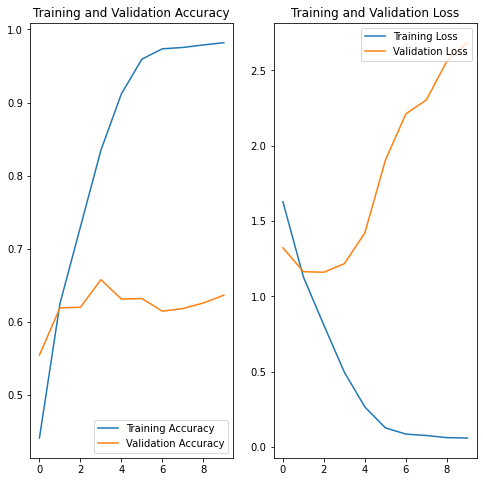

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

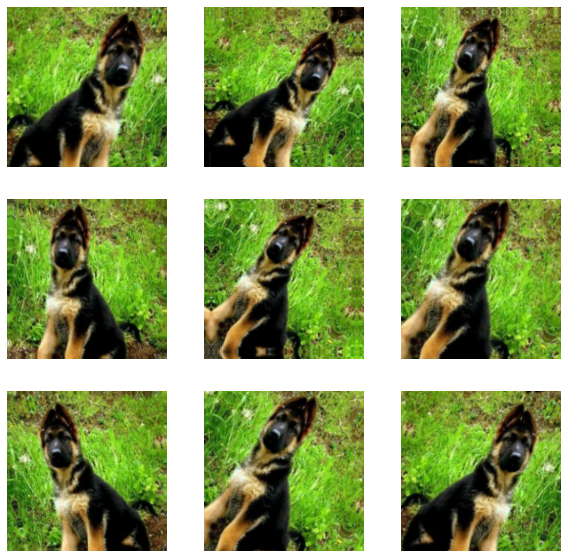

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
655/655 [==============================] - 403s 614ms/step - loss: 2.0480 - accuracy: 0.2809 - val_loss: 1.6248 - val_accuracy: 0.4607
Epoch 2/15
655/655 [==============================] - 381s 582ms/step - loss: 1.5095 - accuracy: 0.4757 - val_loss: 1.4294 - val_accuracy: 0.5016
Epoch 3/15
655/655 [==============================] - 382s 583ms/step - loss: 1.3082 - accuracy: 0.5560 - val_loss: 1.3082 - val_accuracy: 0.5599
Epoch 4/15
655/655 [==============================] - 406s 620ms/step - loss: 1.1913 - accuracy: 0.5959 - val_loss: 1.3691 - val_accuracy: 0.5394
Epoch 5/15
655/655 [==============================] - 377s 575ms/step - loss: 1.1097 - accuracy: 0.6265 - val_loss: 1.4135 - val_accuracy: 0.5251
Epoch 6/15
655/655 [==============================] - 370s 565ms/step - loss: 1.0539 - accuracy: 0.6383 - val_loss: 1.1909 - val_accuracy: 0.6059
Epoch 7/15
655/655 [==============================] - 352s 537ms/step - loss: 0.9886 - accuracy: 0.6635 - val_loss: 1.2941 -

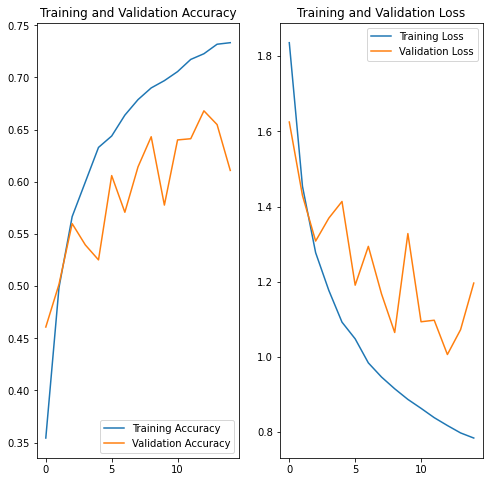

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_anima

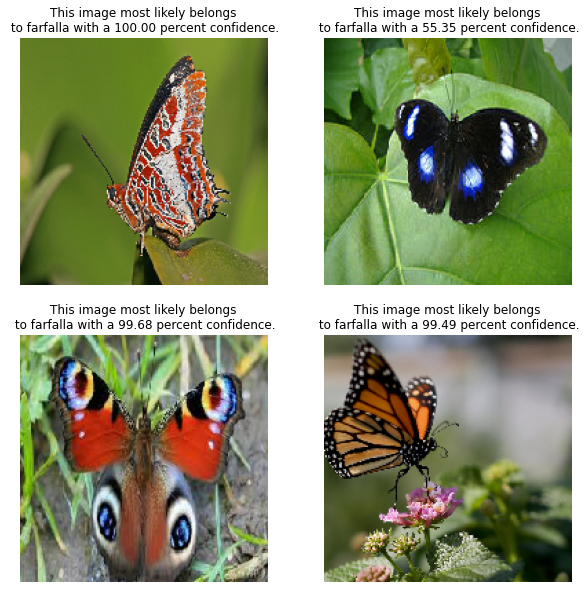

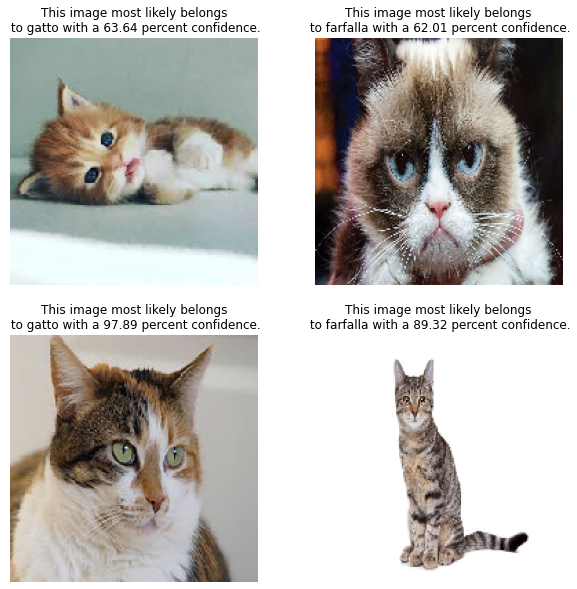

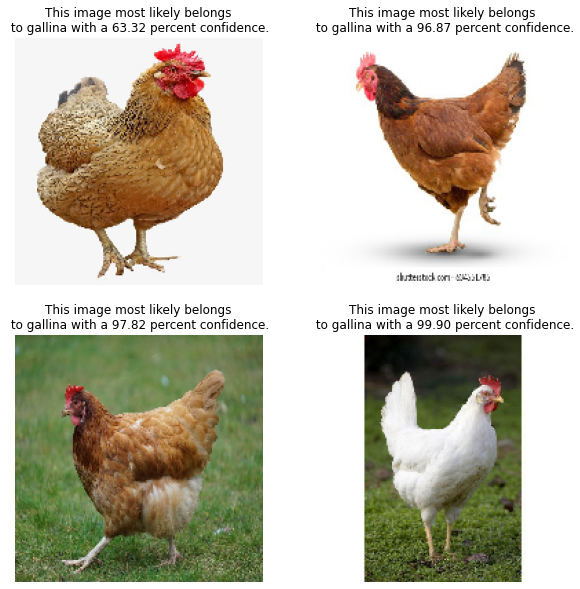

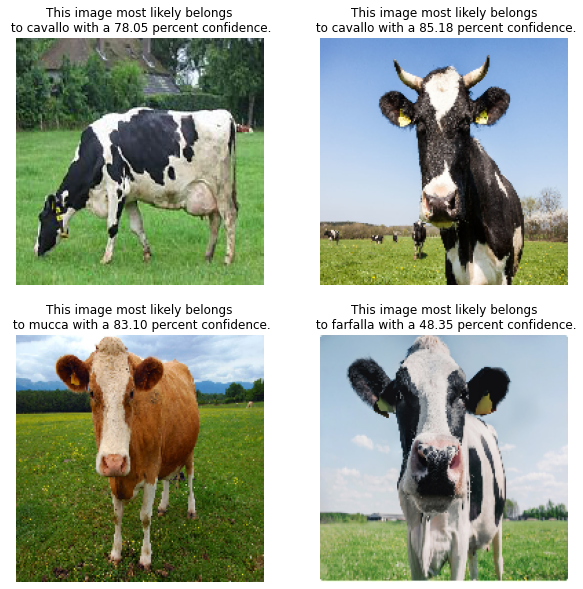

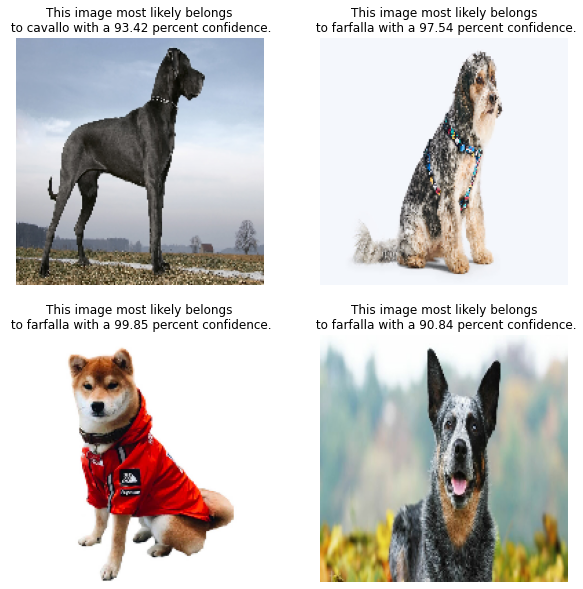

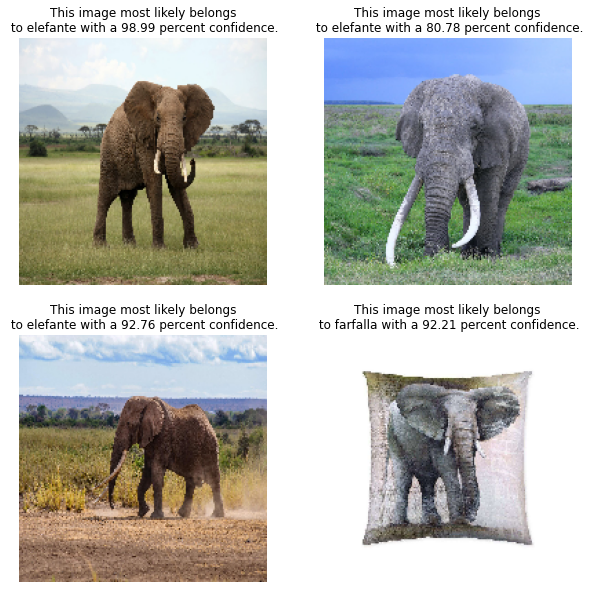

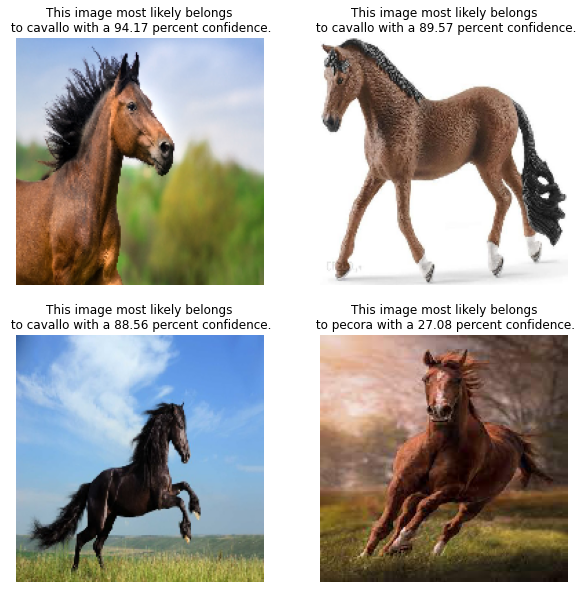

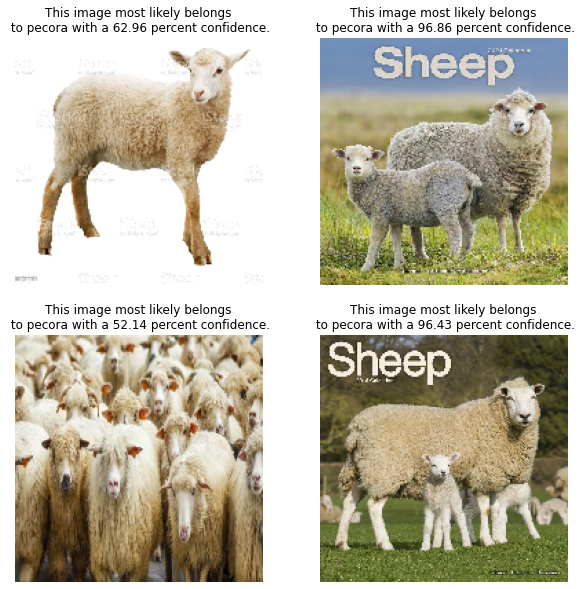

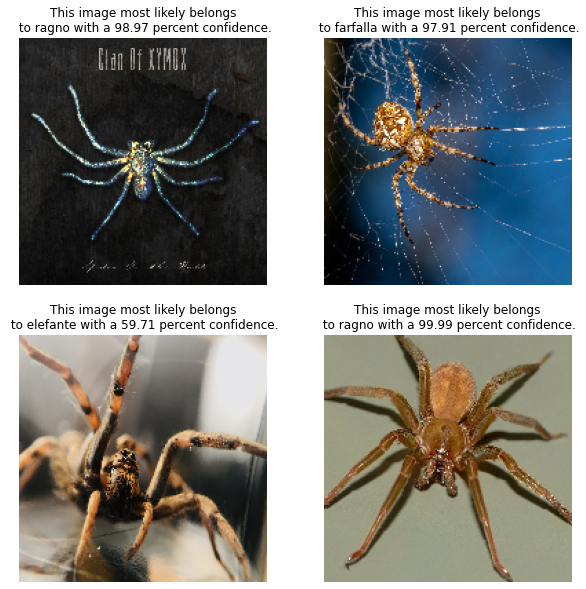

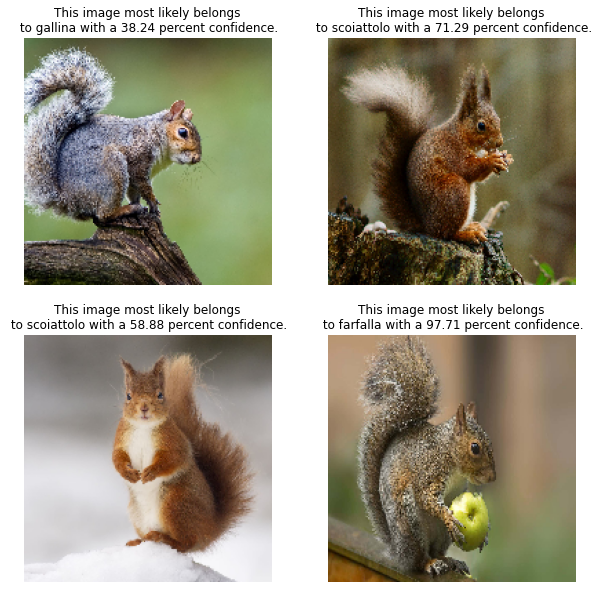

In [76]:
import pathlib
anim = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
for j in anim:
    test_path = pathlib.Path.cwd() / 'test_animals/{}'.format(j)

    #wiewiorka_url = "https://skarpetoholik.pl/4809-large_default/pin-motyl-monarcha-.jpg"
    #wiewiorka_path = tf.keras.utils.get_file('motyl3', origin=wiewiorka_url)

    #img = keras.preprocessing.image.load_img(
    #    wiewiorka_path, target_size=(img_height, img_width)
    #)
    #img_array = keras.preprocessing.image.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0) # Create a batch

    #predictions = model.predict(img_array)
    #score = tf.nn.softmax(predictions[0])

    #print(
     #   "This image most likely belongs to {} with a {:.2f} percent confidence."
     #   .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)


    plt.figure(figsize=(10, 10))
    for i in range(4):
        temp = (test_path / '{}.jpg' .format(j + str(i+1)))
        print(temp)
        img = keras.preprocessing.image.load_img(
        temp, target_size=(img_height, img_width))

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title("This image most likely belongs\n to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")